# Results check 

This notebook confirms that the results output by `src`, e.g. the synthetic data, the Kalman tracking etc. all look reasonable and nothing odd is going on 

# Setup 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../src") # Remove src if already exists 
except:
    pass
sys.path.append("../src") # Means that I dont have to make src/ a proper python package

# Synthetic data 

We generate synthetic data to test our scheme. 

Lets make sure this looks reasonable 

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData

P   = SystemParameters()    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    

first state phase value =  0.0
first state frequency value =  0.0


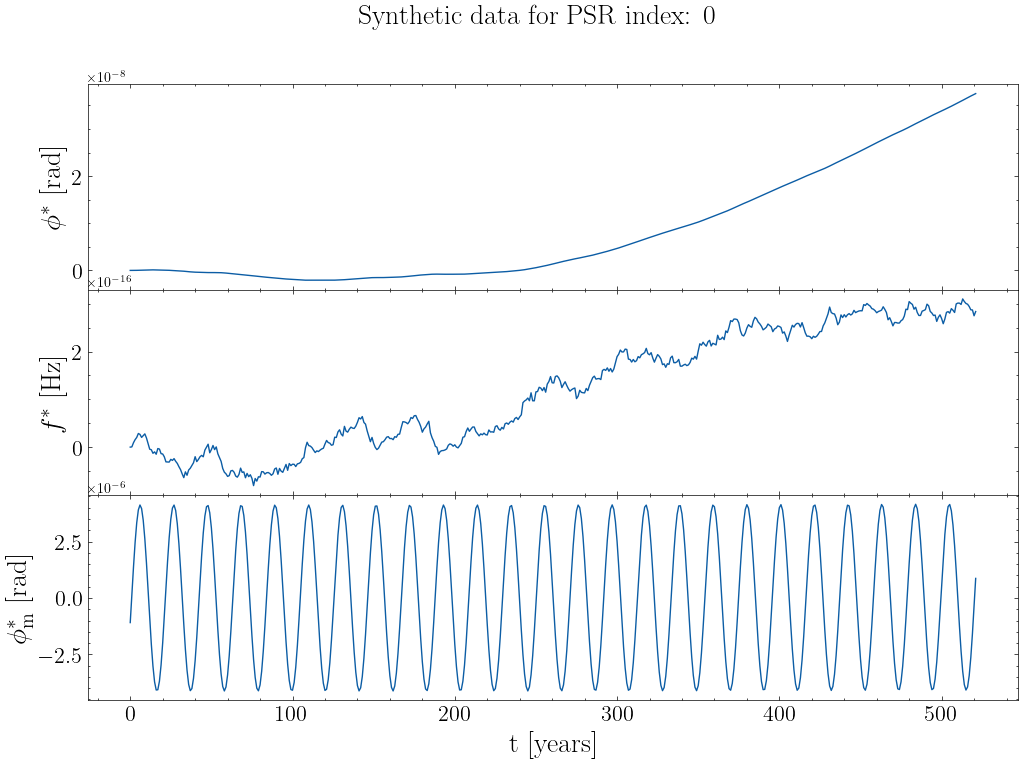

In [4]:
from plotting import plot_synthetic_data
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0)

Looks reasonable. The measurement (bottom panel) looks a bit clean. We can crank the noise to be higher.


For the frequency domain, we approximated the measurement noise on the frequency as 

$$ \frac{\sigma}{f} \sim \frac{\sigma_{\rm TOA}}{T_{\rm cad}}$$


We can do something analogous here:
$$ \frac{\sigma(\phi)}{\phi} \sim \frac{\sigma_{\rm TOA}}{T_{\rm cad}}$$


I think $\phi$ should be treated analogously to the cadence i.e. its not just $2 \pi$, but $2 \pi \times$ number of pulsar rotations. Therefore

$$ \frac{\sigma(\phi)}{2 \pi f T_{\rm cad}} \sim \frac{\sigma_{\rm TOA}}{T_{\rm cad}}$$

or 


$$ \sigma(\phi) \sim 2 \pi f \sigma_{\rm TOA} $$


Take $f = 100$ Hz and $ \sigma_{\rm TOA} \sim 1 \mu$ s gives $\sigma(\phi) \sim 2 \pi \times 10^{-4}$. If the timing precision is good, then $ \sigma_{\rm TOA} \sim 10$ ns gives $\sigma(\phi) \sim 2 \pi \times 10^{-6}$ 


first state phase value =  0.0
first state frequency value =  0.0


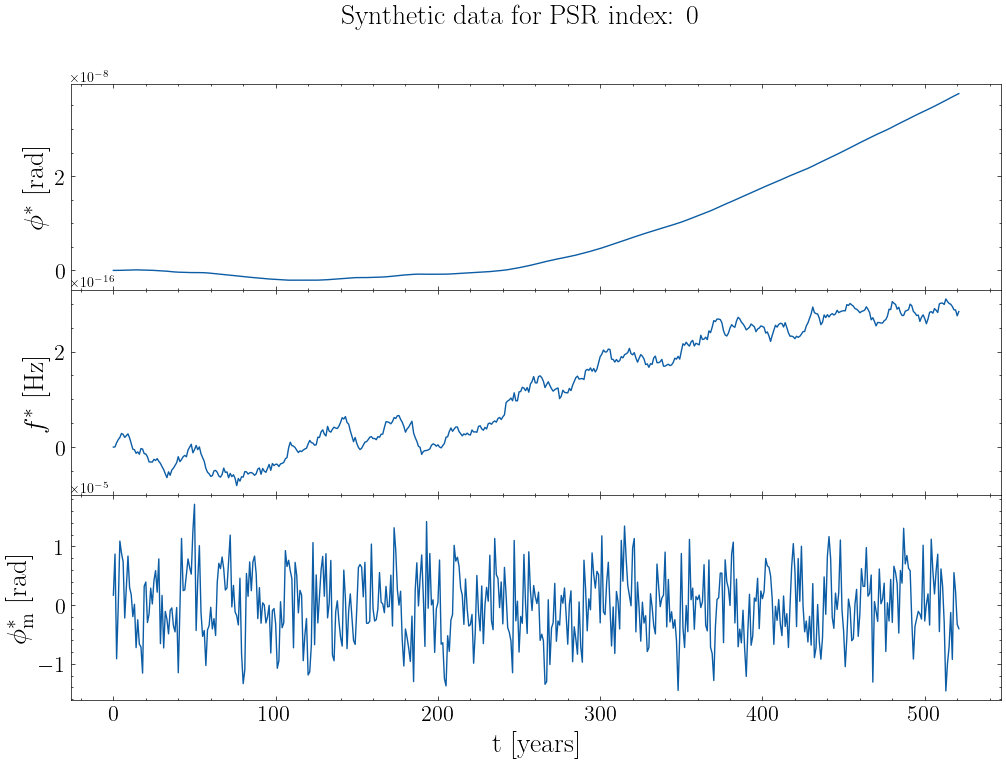

In [6]:
P   = SystemParameters(σm=5e-6)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0)

Lets crank the noise some more, just to see where we lose the sinusoid in the measured data 

first state phase value =  0.0
first state frequency value =  0.0


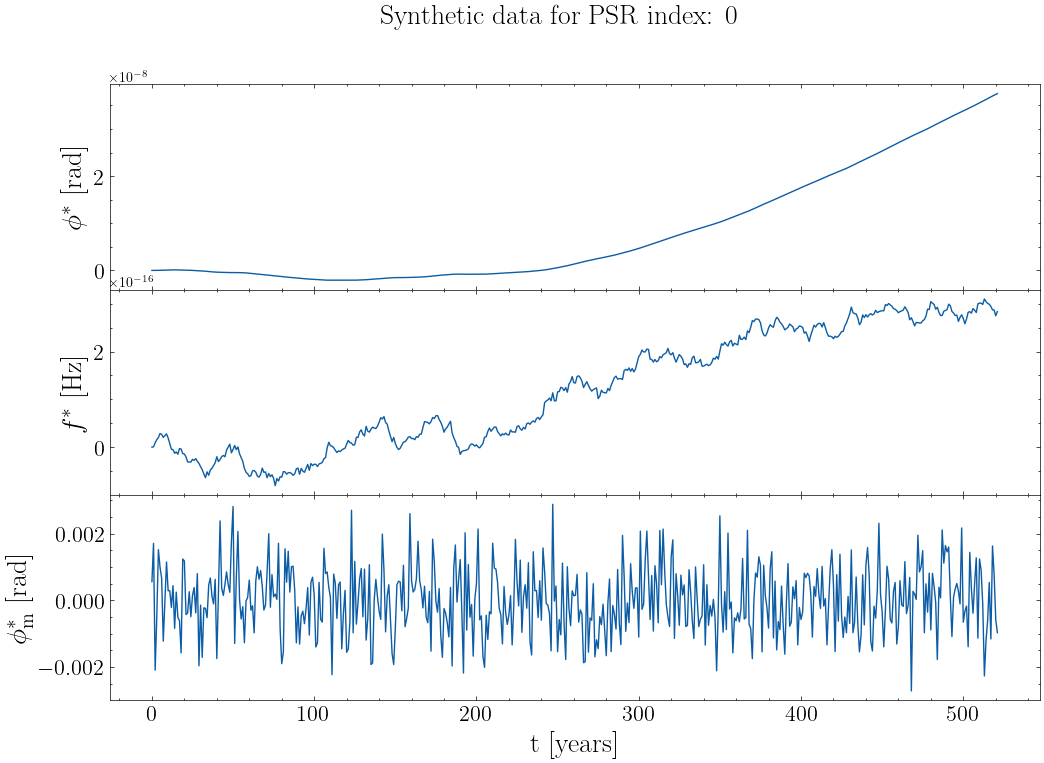

In [7]:
P   = SystemParameters(σm=1e-3)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0)

Notice how the states in the above plots are identical, despite being stochastic processes.

This is because we have seeded the random-ness. If we try a different seed, the state evolution should be different:

first state phase value =  0.0
first state frequency value =  0.0


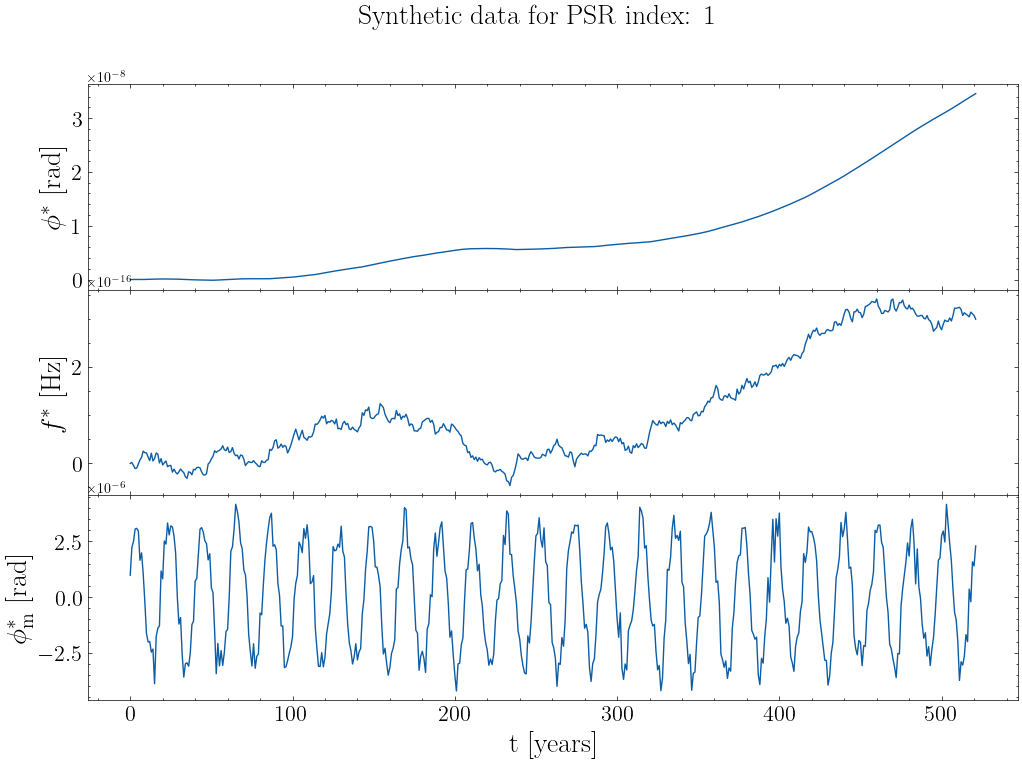

In [8]:
P   = SystemParameters(σm=5e-7,seed=1230)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=1)

Looks good!

# Kalman filter 

We have confirmed that our data looks ok. How does our KF do when we run it on the data? Lets start with an easy very low noise case

In [17]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import PhaseModel
from kalman_filter import KalmanFilter
from priors import bilby_priors_dict


P   = SystemParameters(σm=5e-11)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P,PTA)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling
import numpy as np 

init_parameters,constrained_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
optimal_parameters = constrained_prior.sample(1)
ll,xresults,yresults = KF.likelihood_plotter(optimal_parameters)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1234
INFO:root:The values for χ are as follows: [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


first state phase value =  0.0
first state frequency value =  0.0
The likelihood is 466164.0459407076


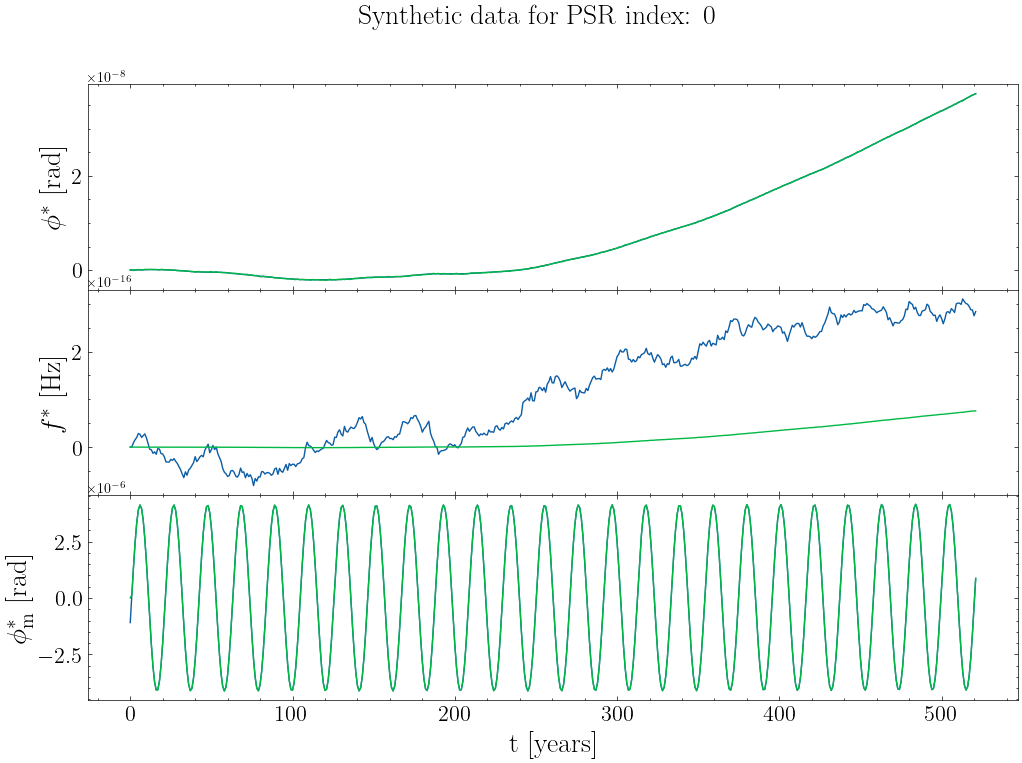

In [18]:
#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")

That looks reasonable. The $\phi$ state and the measurement state are well tracked. The $f$ state is less well tracked, but this is a pure stochastic process. I don't think we should be able to track it...?

What happens if we crank the measurement noise again?



INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1230
INFO:root:The values for χ are as follows: [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


first state phase value =  0.0
first state frequency value =  0.0
The likelihood is 264517.1123647533


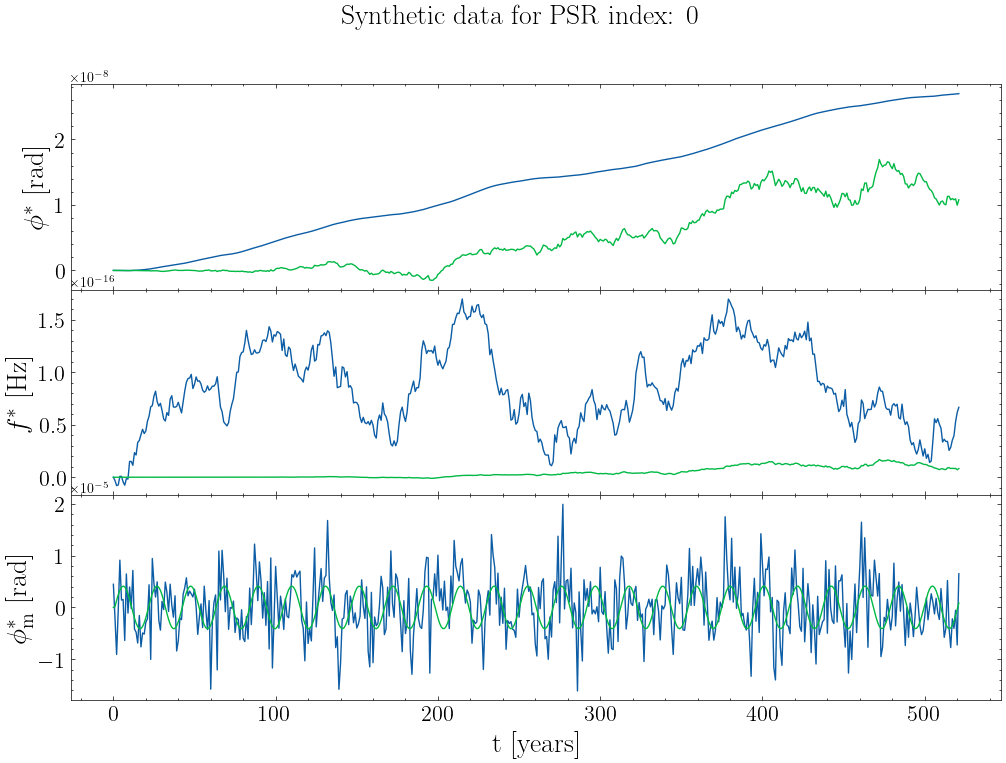

In [20]:
P   = SystemParameters(seed=1230,Npsr=0,σm=5e-6)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P,PTA)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling


init_parameters,constrained_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
optimal_parameters = constrained_prior.sample(1)
ll,xresults,yresults = KF.likelihood_plotter(optimal_parameters)

#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")


Ok now the likelihood is worse (makes sense, more noise) and the state estimates are generally less good, especially at the start, but projecting the states into the measurement space gives decent results. 

If we pass the wrong parameters, the likelihood should be less and the filter should be worse:

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1230
INFO:root:The values for χ are as follows: [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting uninformative priors on GW parameters. NOTE: this needs updating
INFO:root:Setting uninformative priors on PSR parameters. NOTE: just a place holder and need updating to be accurate


first state phase value =  0.0
first state frequency value =  0.0
The likelihood is 213516.0952288432


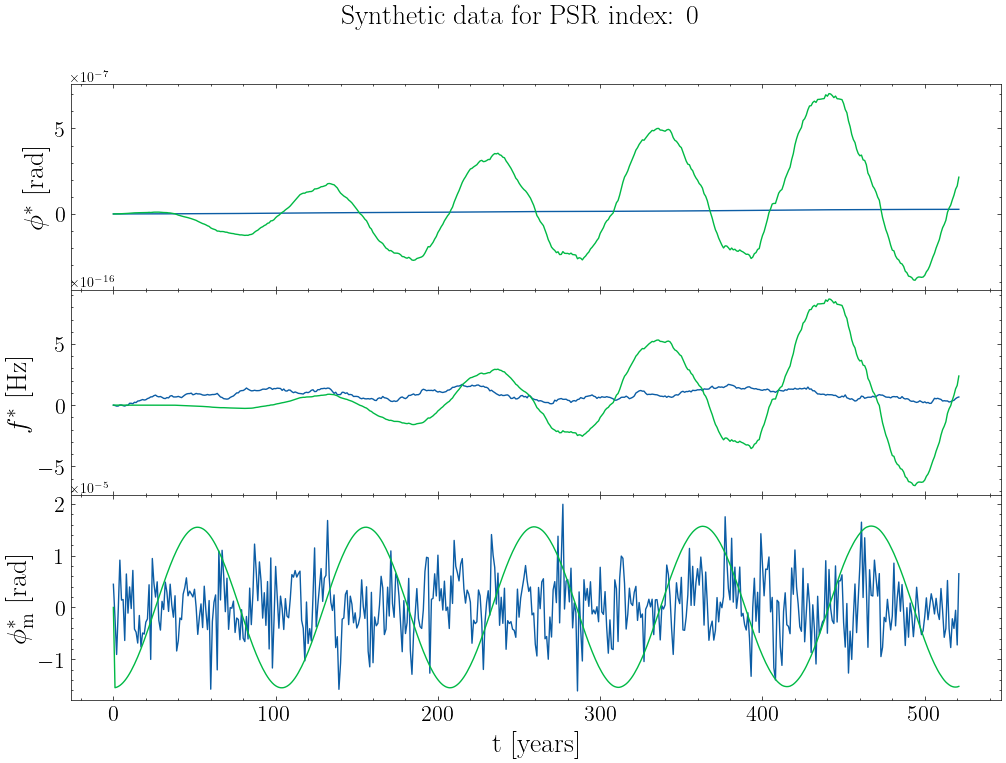

In [22]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import PhaseModel
from kalman_filter import KalmanFilter
from priors import bilby_priors_dict


P   = SystemParameters(seed=1230,σm=5e-6)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P,PTA)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling


init_parameters,loose_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=False,set_measurement_parameters_as_known=False)
sub_optimal_parameters = loose_prior.sample(1)
sub_optimal_parameters["omega_gw"] = np.array([1e-7])
ll,xresults,yresults = KF.likelihood_plotter(sub_optimal_parameters)

#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")